## Performance comparison between direct and ZDD methods

This example shows computational times for enumerating fcc derivative structures by the direct and ZDD methods.

### Import modules and prepare helper functions

In [1]:
from time import time

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from dsenum import StructureEnumerator, ZddStructureEnumerator
from dsenum.utils import get_lattice

%matplotlib inline

In [2]:
from dsenum import __version__
print(f"dsenum {__version__}")

dsenum 0.3.16.dev19+gc2b1184.d20220615


In [3]:
# Plotting settings
sns.set_context('poster')
plt.rcParams['grid.linewidth'] = 0.2

In [4]:
def timer(f):
    def wrapper(*args, **kwargs):
        start = time()
        ret = f(*args, **kwargs)
        elapsed = time() - start
        return elapsed, ret
    return wrapper

@timer
def direct_enumeration(aristo, index, num_types):
    zse = StructureEnumerator(
        aristo,
        index,
        num_types,
        color_exchange=False,
        remove_incomplete=False,
        remove_superperiodic=False,
        verbose=False,
    )
    list_dstructs = zse.generate(output="poscar")
    return len(list_dstructs)

@timer
def zdd_enumeration(aristo, index, num_types, count=False):
    zse = ZddStructureEnumerator(
        aristo,
        index,
        num_types,
        remove_incomplete=False,
        remove_superperiodic=False,
        verbose=False,
    )
    if count:
        return zse.count()
    else:
        return len(zse.generate(output="poscar"))

### Measure computational time

In [5]:
aristo = get_lattice('fcc')
num_types_and_max_index = [(2, 18), (3, 12), (4, 10)]

all_datum = []
for num_types, max_index in num_types_and_max_index:
    for index in range(1, max_index + 1):
        zdd_elapsed, count1 = zdd_enumeration(aristo, index, num_types, count=False)
        zdd_count_elapsed, count1 = zdd_enumeration(aristo, index, num_types, count=True)
        direct_elapsed, count2 = direct_enumeration(aristo, index, num_types)
        assert count1 == count2
        data = {
            "index": index,
            "num_types": num_types,
            "count": count1,
            "zdd_sec": zdd_elapsed,
            "zdd_count_sec": zdd_count_elapsed,
            "direct_sec": direct_elapsed,
        }
        all_datum.append(data)

df = pd.DataFrame(all_datum)

### Plot

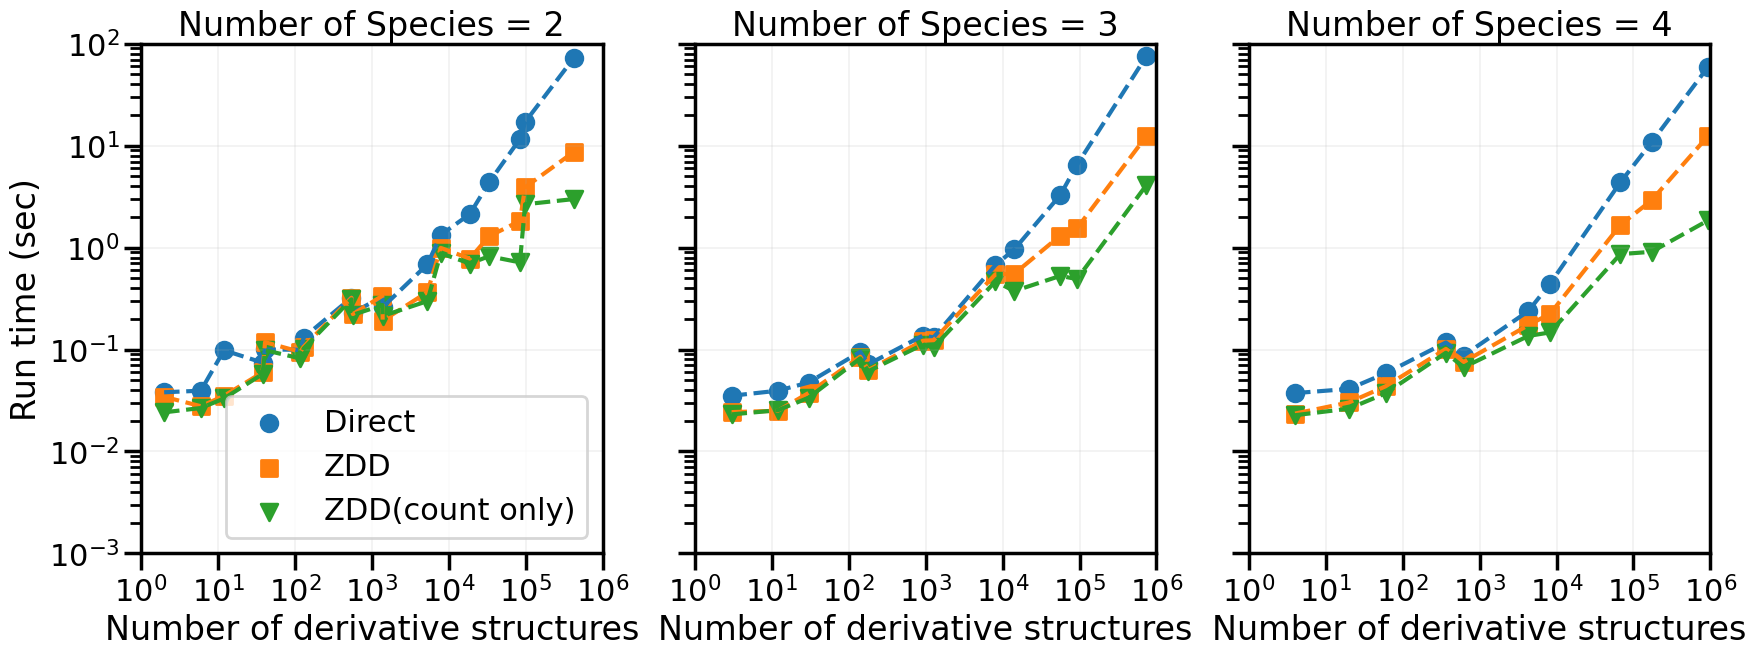

In [6]:
def plotter(fig, ax, df):
    for i, num_types in enumerate([2, 3, 4]):
        df_tmp = df[(df["count"] > 0) & (df["num_types"] == num_types)].sort_values(by=["count"])

        list_count = df_tmp["count"]
        list_direct_sec = df_tmp["direct_sec"]
        list_zdd_sec = df_tmp["zdd_sec"]
        list_zdd_count_sec = df_tmp["zdd_count_sec"]

        ax[i].scatter(list_count, list_direct_sec, label="Direct", color="C0", marker="o")
        ax[i].plot(list_count, list_direct_sec, color="C0", linestyle="--")

        ax[i].scatter(list_count, list_zdd_sec, label="ZDD", color="C1", marker="s")
        ax[i].plot(list_count, list_zdd_sec, color="C1", linestyle="--")
        
        ax[i].scatter(list_count, list_zdd_count_sec, label="ZDD(count only)", color="C2", marker="v")
        ax[i].plot(list_count, list_zdd_count_sec, color="C2", linestyle="--")

        ax[i].set_xscale("log")
        ax[i].set_xlabel("Number of derivative structures")
        ax[i].set_title(f"Number of Species = {num_types}")
        ax[i].grid()

    ax[0].set_ylabel("Run time (sec)")
    ax[0].set_yscale("log")
    ax[0].legend()

    yticks = [10**i for i in range(-3, 2 + 1)]
    ax[0].set_yticks(yticks)
    ax[0].set_ylim(min(yticks), max(yticks))

    xticks = [10**i for i in range(0, 6 + 1)]
    ax[0].set_xticks(xticks)
    ax[0].set_xlim(min(xticks), max(xticks))
    return fig, ax

fig, ax = plt.subplots(1, 3, figsize=(6.75 * 3, 6.75), dpi=100,
                       sharex=True, sharey=True)
fig, ax = plotter(fig, ax, df)
